In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate
from sklearn.model_selection import learning_curve
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
import time
import os
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
# Read the training data
train = pd.read_csv(r'D:\DownloadsD\Train_data.csv')
test = pd.read_csv(r'D:\DownloadsD\Test_data.csv')

# Display summary statistics for categorical variables
train.describe(include='object')

# Check the shape of the training data
print("Shape of training data:", train.shape)

# Check for missing values in the training data
print("Missing values in training data:")
print(train.isnull().sum())

Shape of training data: (25192, 42)
Missing values in training data:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_sr

Number of duplicate rows: 0


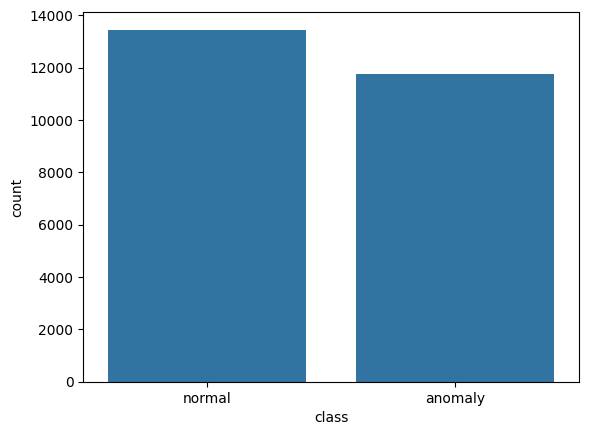

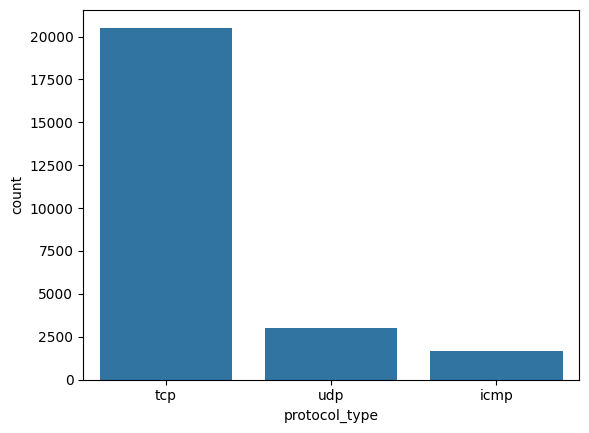

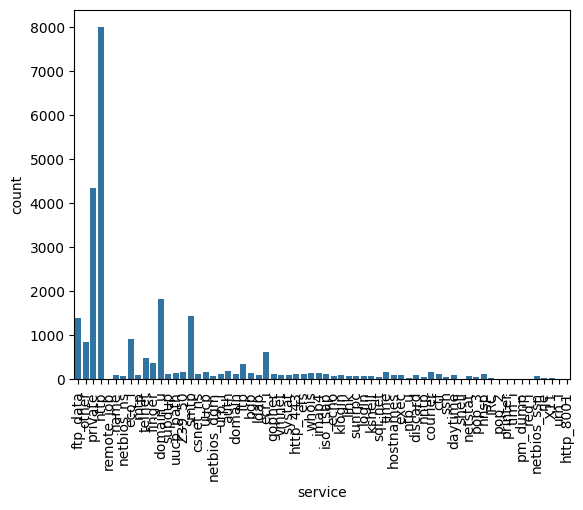

Class distribution Training set:
class
normal     13449
anomaly    11743
Name: count, dtype: int64


In [3]:
# Calculate the percentage of missing values for each column
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

# Check for duplicate rows in the training data
print(f"Number of duplicate rows: {train.duplicated().sum()}")

# Plot the distribution of the target variable 'class'
sns.countplot(x=train['class'])
plt.show()  # Display the plot
sns.countplot(x=train['protocol_type'])
plt.show()  # Display the plot
sns.countplot(x=train['service'])
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', pad=5)
plt.show()  # Display the plot

print('Class distribution Training set:')
print(train['class'].value_counts())

In [4]:
# Check data
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,24330.628215,3491.847174,0.000079,0.023738,0.000040,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.000000,0.000000,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2410805.402028,88830.718330,0.008910,0.260221,0.006300,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.000000,0.000000,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,279.000000,530.250000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,381709090.000000,5151385.000000,1.000000,3.000000,1.000000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.000000,0.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


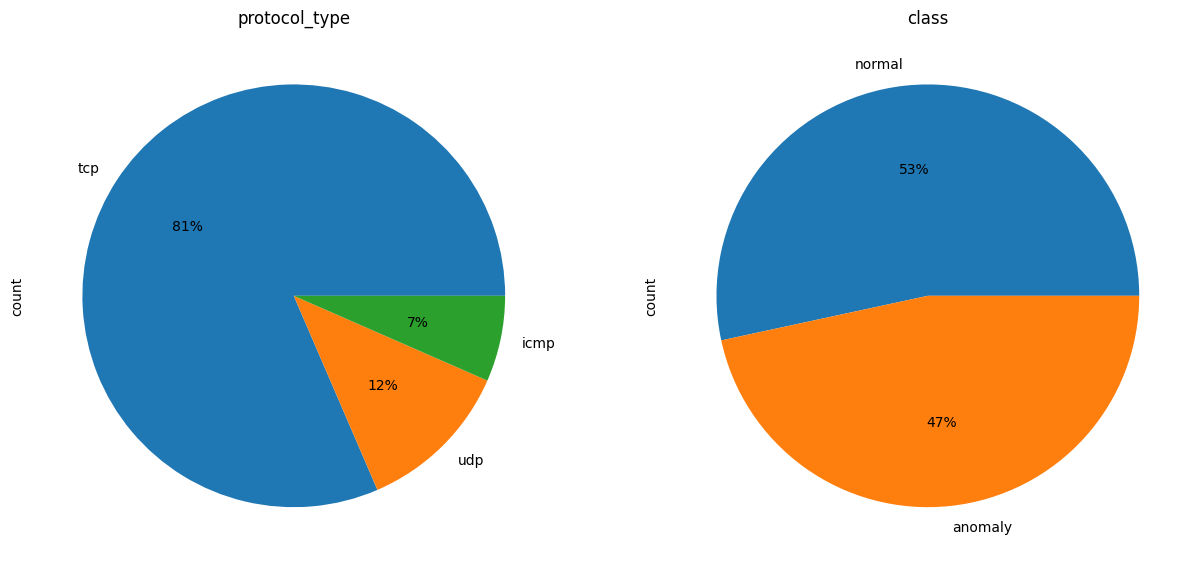

In [6]:
train.loc[train['class'] == "normal", "class"] = 'normal'
train.loc[train['class'] != 'normal', "class"] = 'anomaly'

# Define the function
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)

# Call the function
pie_plot(train, ['protocol_type', 'class'], 1, 2)
plt.show()

<Figure size 1500x300 with 0 Axes>

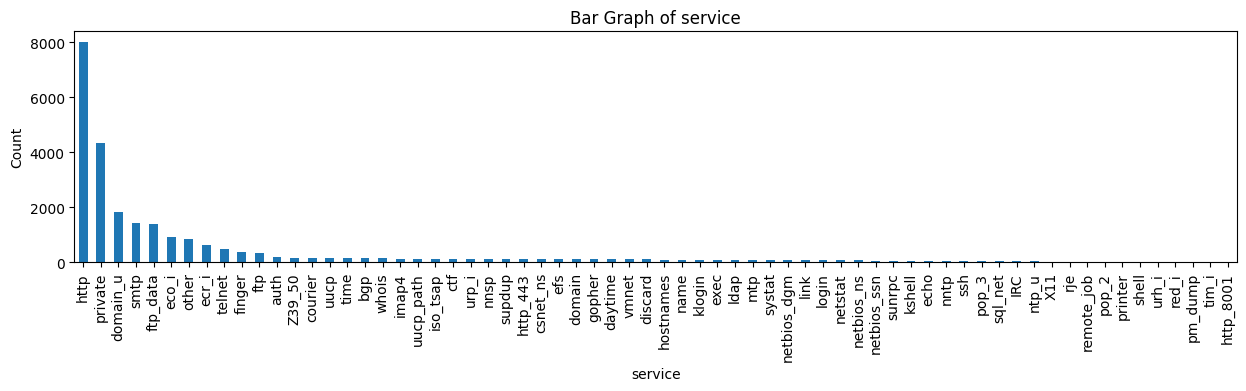

In [7]:

def bar_graph(feature, train):
    if feature in train.columns:
        data = train[feature].value_counts().to_dict()
        plt.figure(figsize=(15, 3))
        pd.Series(data).plot(kind="bar")
        plt.title(f"Bar Graph of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"Error: Column '{feature}' does not exist in the DataFrame.")

# Assuming 'df' is your DataFrame
# Set the figure size
plt.figure(figsize=(15, 3))
# Call the function to plot the bar graph for the 'service' feature
bar_graph('service', train)

<Figure size 1500x300 with 0 Axes>

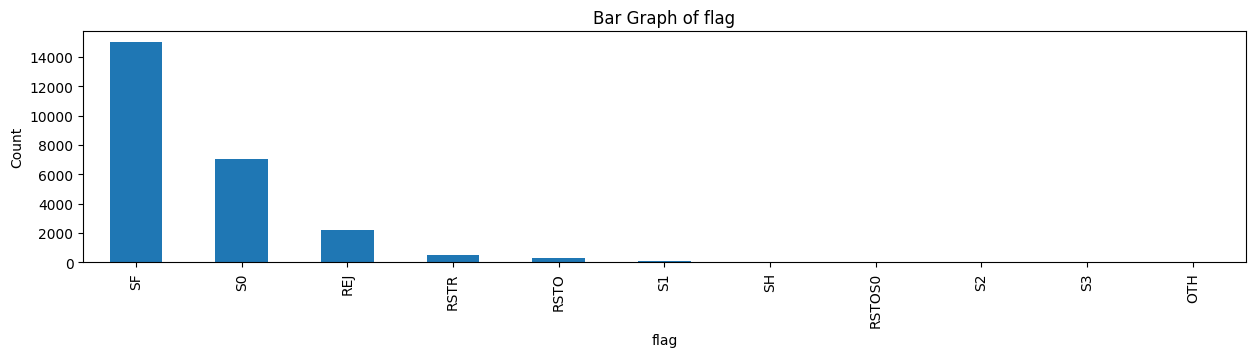

In [8]:
def bar_graph(feature, data_train):
    if feature in train.columns:
        data = train[feature].value_counts().to_dict()
        plt.figure(figsize=(15, 3))
        pd.Series(data).plot(kind="bar")
        plt.title(f"Bar Graph of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"Error: Column '{feature}' does not exist in the DataFrame.")

# Assuming 'df' is your DataFrame
# Set the figure size
plt.figure(figsize=(15, 3))
# Call the function to plot the bar graph for the 'service' feature
bar_graph('flag', train)

<Figure size 1500x300 with 0 Axes>

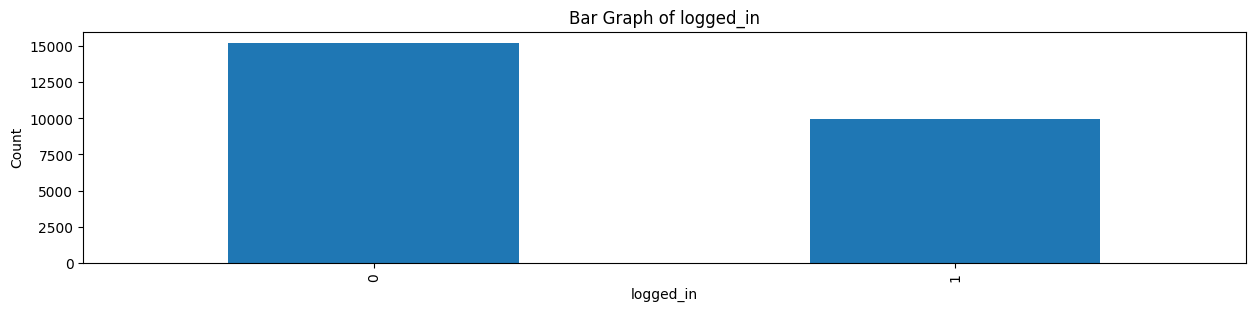

In [9]:
def bar_graph(feature, data_train):
    if feature in train.columns:
        data = train[feature].value_counts().to_dict()
        plt.figure(figsize=(15, 3))
        pd.Series(data).plot(kind="bar")
        plt.title(f"Bar Graph of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"Error: Column '{feature}' does not exist in the DataFrame.")

# Assuming 'df' is your DataFrame
# Set the figure size
plt.figure(figsize=(15, 3))
# Call the function to plot the bar graph for the 'service' feature
bar_graph('logged_in', train)

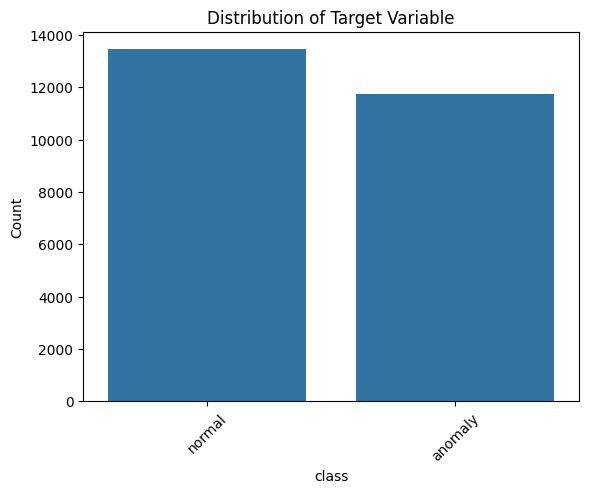

In [10]:
#plot the distrubution of the target variable
#sns.countplot(x=data_train['outcome']) 
#plt.show()

sns.countplot(x='class', data=train)
plt.title('Distribution of Target Variable')
plt.xlabel('class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [11]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [12]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

print(train.head())


X_train = train.drop(['class'], axis=1)
Y_train = train['class']

rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

print(selected_features)

X_train = X_train[selected_features]
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

print(x_train.shape)

print(x_test.shape)
 


   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       19     9        491          0     0   
1         0              2       41     9        146          0     0   
2         0              1       46     5          0          0     0   
3         0              1       22     9        232       8153     0   
4         0              1       22     9        199        420     0   

   wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  \
0               0       0    0                  0          0                0   
1               0       0    0                  0          0                0   
2               0       0    0                  0          0                0   
3               0       0    0                  0          1                0   
4               0       0    0                  0          1                0   

   root_shell  su_attempted  num_root  num_file_creations  num_shells  \
0

Training time:  0.06078910827636719
Testing time:  0.0010046958923339844
Training Score: 0.9314959736871952
Test Score: 0.9252447737496692


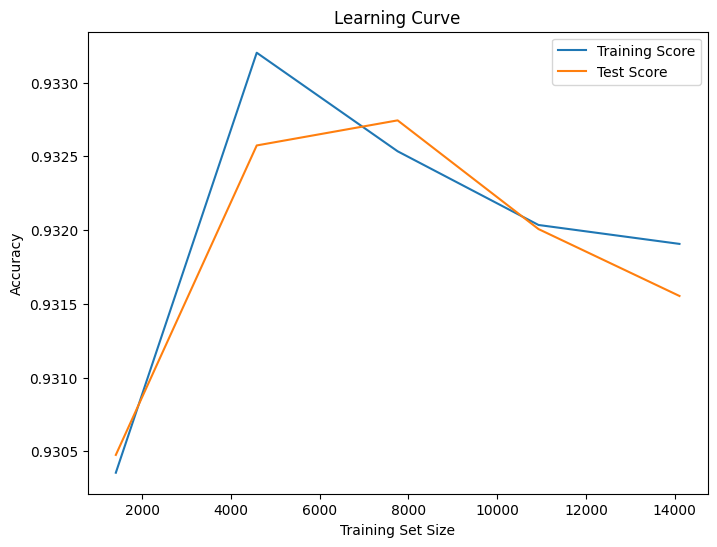

FrozenTrial(number=0, state=1, values=[0.9767134162476846], datetime_start=datetime.datetime(2024, 6, 11, 23, 57, 17, 42341), datetime_complete=datetime.datetime(2024, 6, 11, 23, 57, 19, 922104), params={'KNN_n_neighbors': 11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)
Train Score: 0.981229443121243
Test Score: 0.9767134162476846
Training time:  0.06032609939575195
Testing time:  0.010970354080200195


In [13]:
import time

from sklearn.linear_model import LogisticRegression
  
clfl = LogisticRegression(max_iter = 1200000)
start_time = time.time()
clfl.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

start_time = time.time()
y_test_pred = clfl.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)


lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")



  

 
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(lg_model, x_train, y_train, cv=5)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1) 
print(study_KNN.best_trial)


KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")






from sklearn.tree import DecisionTreeClassifier
  
clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)


start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)


def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

FrozenTrial(number=28, state=1, values=[0.9947075946017465], datetime_start=datetime.datetime(2024, 6, 11, 23, 57, 31, 334651), datetime_complete=datetime.datetime(2024, 6, 11, 23, 57, 31, 504773), params={'dt_max_depth': 21, 'dt_max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=28, value=None)
Train Score: 0.9999432913689463
Test Score: 0.9940460439269648
╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.981229 │     0.976713 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.931496 │     0.925245 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999943 │     0.994046 │
╘══════════

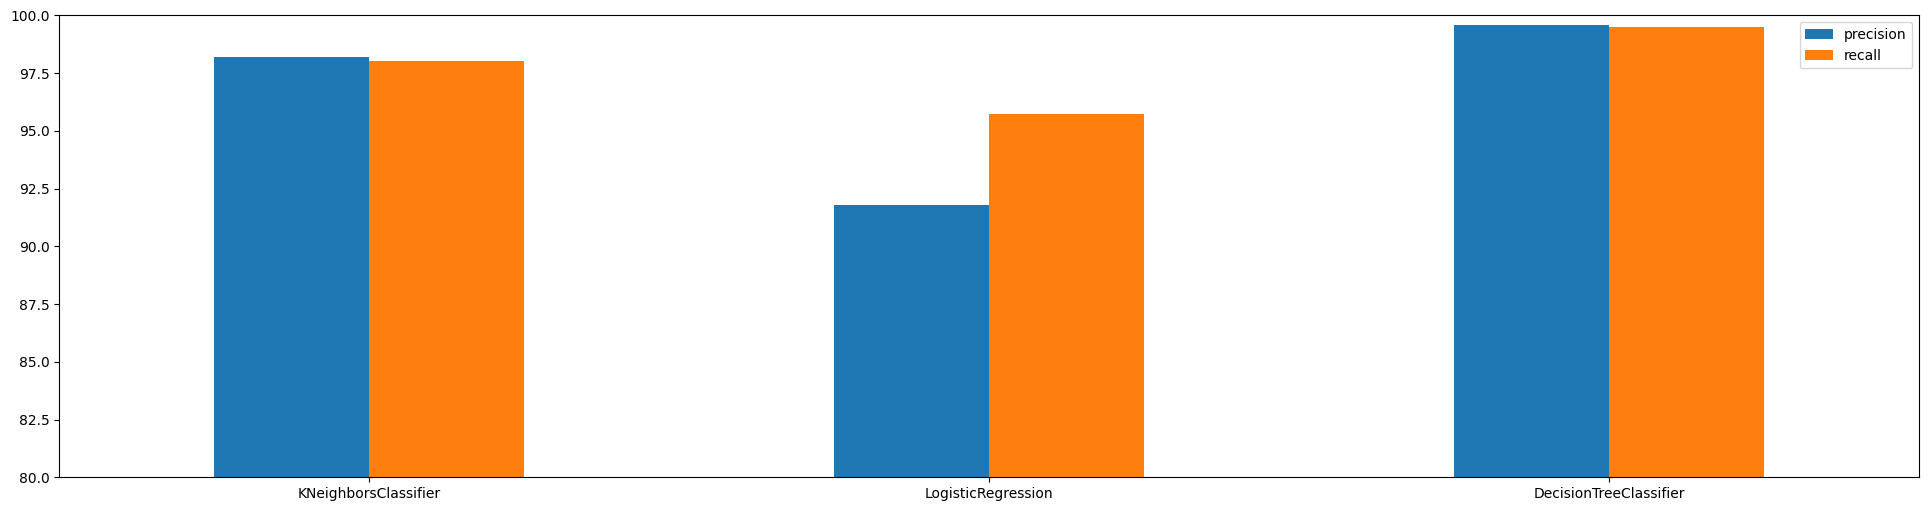

Predictions complete.
*************** KNeighborsClassifier Model Testing ***************
[[3423   75]
 [  94 3966]]
---------------
              precision    recall  f1-score   support

      normal       0.97      0.98      0.98      3498
     anamoly       0.98      0.98      0.98      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558

**************** LogisticRegression Model Testing ****************
[[3131  367]
 [ 198 3862]]
----------------
              precision    recall  f1-score   support

      normal       0.94      0.90      0.92      3498
     anamoly       0.91      0.95      0.93      4060

    accuracy                           0.93      7558
   macro avg       0.93      0.92      0.92      7558
weighted avg       0.93      0.93      0.93      7558

************** DecisionTreeClassifier Model Testing **************
[[3479   19]
 [  28 4032]]
---------

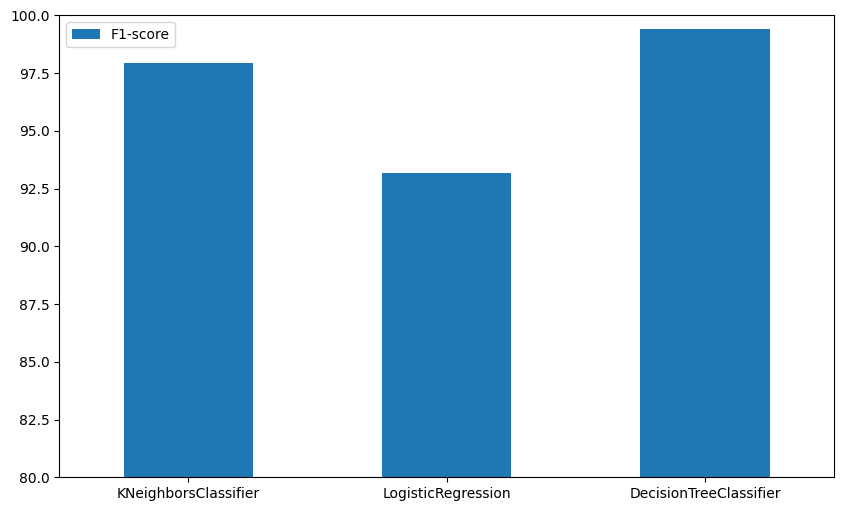

In [14]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)



dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")


data = [["KNN", KNN_train, KNN_test], 
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


SEED = 42

# Decision Tree Model
dtc = DecisionTreeClassifier()

# KNN
knn = KNeighborsClassifier()

# LOGISTIC REGRESSION MODEL

lr = LogisticRegression()

from sklearn.model_selection import cross_val_score
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc



scores = {}
for name in models:
  scores[name]={}
  for scorer in ['precision','recall']:
    scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)



def line(name):
  return '*'*(25-len(name)//2)

for name in models:
  print(line(name), name, 'Model Validation', line(name))

  for scorer in ['precision','recall']:
    mean = round(np.mean(scores[name][scorer])*100,2)
    stdev = round(np.std(scores[name][scorer])*100,2)
    print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
    print()   

for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)
plt.show()

models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc


preds={}
for name in models:
    models[name].fit(x_train, y_train)
    preds[name] = models[name].predict(x_test)
print("Predictions complete.")



from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["normal","anamoly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))


f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
f1s.plot(kind = "bar",  ylim=[80,100], figsize=(10,6), rot=0)
plt.show()

In [15]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib
import webbrowser
from flask_cors import CORS

In [18]:

app = Flask(__name__)
CORS(app, resources={r"/predict": {"origins": "*"}})  # Allow CORS for '/predict' endpoint from all origins

# Load the trained model
model = joblib.load(r'D:\DownloadsD\DecisionTreeClassifier.pkl')
webbrowser.open_new_tab(r'D:\DownloadsD\index (2).html')

@app.route('/predict', methods=['POST'])
def predict():
    # Get the request data
    data = request.get_json()
    
    # Convert the JSON data to a DataFrame with a default index
    df = pd.DataFrame(data, index=[0])
    
    # Encode categorical variables
    df_encoded = pd.get_dummies(df)  # Assuming one-hot encoding
    
    # Make predictions
    predictions = model.predict(df_encoded)
    
    # Return the predictions as JSON
    return jsonify({'predictions': predictions.tolist()})

if __name__ == '__main__':
    app.run(debug=False, port=5002)
    




 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit
127.0.0.1 - - [12/Jun/2024 00:03:58] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [12/Jun/2024 00:03:59] "POST /predict HTTP/1.1" 200 -
